# Tutorial 1: Top-Hat Jet Model (Flat $\theta_c$ Distribution)

This tutorial demonstrates the **flat top-hat model**, the simplest jet geometry in the MAGGPY framework. We will:

1. Define the prior and parameter space
2. Explain the $\theta_c$ distribution and geometric efficiencies
3. Run a short MCMC
4. Visualize the resulting CDFs
5. Fix a median viewing angle and extract the $f_j$ posterior

---

## The Flat Top-Hat Model

In the top-hat model, the GRB jet has a **uniform** luminosity profile within the core angle $\theta_c$ and zero emission outside. The key simplification compared to the structured jet model is that there is **no time evolution**, we sample the luminosity directly.

The opening angle $\theta_c$ is drawn from a **flat (uniform) distribution** between $\theta_{c,\min} = 1°$ and $\theta_{c,\max}$ (a free parameter).

## Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import notebook_setup

import  src.init
import  emcee
import  corner
import  numpy                   as np
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path

# Top-hat jet model specific modules
from    src.top_hat.montecarlo  import *
from    src.top_hat.plot        import TopHatPlotter
from    src.top_hat.geometric_eff import geometric_efficiency_flat

# Apply custom plotting style
# plt.style.use('../configurations/style.mplstyle') if you have latex
# conda install -n acme_env -c conda-forge texlive-core dvipng cm-super if you want to use the latex style, otherwise use the default matplotlib style or a custom one without latex support. 

## Key Ingredients: The Physics Behind the Model

Before we set up the MCMC, let's walk through the key physical ingredients one by one.

### The Smoothly Broken Power Law (SBPL) Spectrum

The photon spectrum of each GRB follows a **smoothly broken power law**:

$$
N_E^{\text{SBPL}} = C_n \left[ \left( \frac{E}{E_j} \right)^{-\alpha\, n} + \left( \frac{E}{E_j} \right)^{-\beta\, n} \right]^{-1/n}
$$

where:
- $\alpha = -0.67$ is the **low-energy spectral index** (close to the synchrotron prediction $\alpha = -2/3$)
- $\beta = -2.59$ is the **high-energy spectral index**
- $n = 2$ controls the **smoothness** of the break between the two power laws
- $E_j = E_p / \epsilon$ is the break energy, related to the **peak energy** $E_p$
- $C_n = 2^{1/n}$ is a normalisation constant

The peak of $E^2 N_E$ (the $\nu F_\nu$ spectrum) occurs at $E_p$. This is the quantity we compare to Fermi-GBM observations.

![SBPL Spectrum](images/sbpl_spectrum.png)

### The Cut-off Power Law (Luminosity Function)

The isotropic-equivalent energy $\hat{E}_{\rm iso}$ of each GRB is drawn from a **cut-off power law** (Schechter-like function):

$$
p(\hat{E}_{\rm iso}) \propto \hat{E}_{\rm iso}^{\,-k} \;\exp\!\left(\;\frac{\hat{E}_{\rm iso}}{E_0}\right)^{-k}
$$

The parameter **$k$** controls the shape:
- **Small $k$** ($\sim 1.5$): broad distribution, many high-energy events
- **Large $k$** ($\gtrsim 4$): steep drop-off, most events are low-energy

$E_0$ (parametrised as `L_L0` $= \log_{10}(E_0 / 10^{49}\,\text{erg/s})$) sets the overall energy scale.

![Cut-off Power Law](images/cutoff_power_law.png)

### Peak Energy Distribution ($E_p$)

The **rest-frame peak energy** $E_{p,\text{rest}}$ is drawn from a **log-normal distribution**:

$$
\log_{10}(E_p / \text{keV}) \sim \mathcal{N}(\mu_E,\; \sigma_E)
$$

- `L_mu_E` $= \log_{10}(\mu_E / \text{keV})$: the **mean** of the distribution (typically $\sim 10^{2.5}$–$10^{3.5}$ keV)
- `sigma_E`: the **width** (scatter) of the distribution in log-space

The observed peak energy is redshifted: $E_{p,\text{obs}} = E_{p,\text{rest}} / (1+z)$.

![Peak Energy Distribution](images/epeak_distribution.png)

### The Top-Hat $\theta_c$ Distribution

In the top-hat model, every jet has a **uniform luminosity profile**: full brightness for $\theta_v \leq \theta_c$, and zero outside. The core angle $\theta_c$ is not fixed but drawn from a **flat (uniform) distribution** between:

$$
\theta_c \sim \text{Uniform}(1°,\; \theta_{c,\max})
$$

This means:
- **All angles from 1° to $\theta_{c,\max}$** are equally likely
- The **only free parameter** for the geometry is $\theta_{c,\max}$
- A larger $\theta_{c,\max}$ means wider jets are possible → more detectable GRBs

The figure below shows this flat window and the resulting jet profile:

![Top-Hat Distribution](images/tophat_theta_distribution.png)

### The Jet Fraction $f_j$

The **jet fraction** is defined as the ratio of short GRBs to BNS mergers:

$$
f_j = \frac{N_{\text{sGRB}}}{N_{\text{BNS}}}
$$

Its physical meaning:
- **$f_j \leq 1$** (physical): not every BNS merger produces a detectable sGRB. Some mergers might not launch a jet, or the jet may be too weak. $f_j = 0.3$ means only 30% of BNS mergers produce an observable sGRB.
- **$f_j = 1$**: every BNS merger produces exactly one sGRB.
- **$f_j > 1$** (unphysical): there would be more sGRBs than BNS mergers, which is not possible if BNS mergers are the sole progenitor. Values $f_j > 1$ returned by the MCMC indicate the model is trying to overcompensate for low detection efficiency and may signal model tension.

![fj explanation](images/fj_explanation.png)

### The Cramér–von Mises (CvM) Goodness-of-Fit Test

We need a way to measure how well the simulated GRB observables match the real Fermi-GBM data. We use the **Cramér–von Mises 2-sample test**.

#### Definition

Given two samples $\{x_1, \dots, x_n\}$ (observed) and $\{y_1, \dots, y_m\}$ (simulated), the CvM statistic measures the **integrated squared distance** between their empirical CDFs:

$$
W^2 = \frac{nm}{(n+m)^2} \int_{-\infty}^{\infty} \left[ F_n(x) - G_m(x) \right]^2 \, dH_{n+m}(x)
$$

where $F_n$ and $G_m$ are the empirical CDFs of the two samples and $H_{n+m}$ is the CDF of the **pooled** sample.

#### How we use it
- The test returns a **p-value**: high $p$ means the two distributions are consistent; low $p$ means they differ.
- We compute CvM tests in $\log_{10}$-space for both **peak flux** ($F_p$) and **peak energy** ($E_p$).
- The shape log-likelihood is: $\ln \mathcal{L}_{\rm shape} = \ln p_{\rm CvM}(F_p) + \ln p_{\rm CvM}(E_p)$

The image below illustrates the idea — the shaded area between the two ECDFs is what the CvM statistic captures:

![CvM ECDF explanation](images/cvm_ecdf_explanation.png)

## Setup

In [3]:
datafiles   = Path("../datafiles")
N_WALKERS   = 20

## 1. Parameters and Priors

The flat top-hat model has **6 free parameters** (see the explanations in the section above for physical details):

| Parameter | Symbol | Description | Prior Range |
|-----------|--------|-------------|------------|
| `A_index` | $k$ | Power-law index of the cut-off power law luminosity function | $[1.5, 12]$ |
| `L_L0` | $\log_{10}(L_0/10^{49}\,\text{erg/s})$ | Isotropic energy scale | $[-2, 7]$ |
| `L_mu_E` | $\log_{10}(\mu_E/\text{keV})$ | Mean of the log-normal peak energy distribution | $[0.1, 7]$ |
| `sigma_E` | $\sigma_E$ | Width of peak energy log-normal distribution (in dex) | $[0, 2.5]$ |
| `theta_c_max` | $\theta_{c,\max}$ | Upper bound of the uniform $\theta_c$ window (deg) | $[1, 25]$ |
| `fj` | $f_j = N_{\rm sGRB}/N_{\rm BNS}$ | Jet fraction ($\leq 1$ physical, $>1$ unphysical) | $[0, 10]$ |

We use **flat (uniform) priors** for all parameters.

In [4]:
N_PARAMS    = 6
PARAM_NAMES = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_max", "fj"]

def log_prior_flat_tophat(thetas):
    """Flat (uniform) prior for the top-hat model."""
    A_index, L_L0, L_mu_E, sigma_E, theta_c_max, fj = thetas

    if not (1.5 < A_index       < 12):  return -inf
    if not (-2  < L_L0          < 7):   return -inf
    if not (0.1 < L_mu_E        < 7):   return -inf
    if not (0   < sigma_E       < 2.5): return -inf
    if not (1   < theta_c_max   < 25):  return -inf
    if not (0   < fj            < 10):   return -inf

    return 0.0

print("Prior test (valid point):",   log_prior_flat_tophat([3, 1, 3, 0.5, 10, 0.5]))
print("Prior test (invalid point):", log_prior_flat_tophat([3, 1, 3, 0.5, 30, 0.5]))

Prior test (valid point): 0.0
Prior test (invalid point): -inf


## 2. Geometric Efficiency

The **geometric efficiency** $\epsilon_{\text{geo}}$ is the probability that a randomly oriented observer falls within the jet cone. Let's derive it from scratch.

### Derivation

The viewing angle $\theta_v$ (angle between the jet axis and the line of sight) is distributed as:

$$
p(\theta_v) = \sin\theta_v, \qquad \theta_v \in [0, \pi]
$$

This is because isotropically distributed orientations yield a $\sin\theta_v$ probability density on the sphere (the fraction of solid angle at angle $\theta_v$ is $\propto \sin\theta_v$).

For a top-hat jet with opening angle $\theta_c$, we detect the GRB only if $\theta_v \leq \theta_c$. The geometric efficiency for a **fixed** $\theta_c$ is therefore:

$$
\epsilon_{\text{geo}}^{\text{fixed}}(\theta_c) = \int_0^{\theta_c} \sin\theta_v \, d\theta_v = 1 - \cos\theta_c
$$

> **Example**: for $\theta_c = 3.4° \approx 0.059$ rad, $\epsilon_{\rm geo} = 1 - \cos(3.4°) \approx 1.8 \times 10^{-3}$ — only ~0.2% of orientations fall within the cone!

### Averaging over a flat $\theta_c$ distribution

In our model, $\theta_c$ is not fixed but drawn from $\text{Uniform}(\theta_{c,\min}, \theta_{c,\max})$. The average geometric efficiency is:

$$
\epsilon_{\text{geo}}(\theta_{c,\max}) = \frac{1}{\theta_{c,\max} - \theta_{c,\min}} \int_{\theta_{c,\min}}^{\theta_{c,\max}} (1 - \cos\theta_c) \, d\theta_c = 1 - \frac{\sin\theta_{c,\max} - \sin\theta_{c,\min}}{\theta_{c,\max} - \theta_{c,\min}}
$$

This is a key quantity because the total detection efficiency is:
$$
\epsilon = \epsilon_{\text{geo}} \times f_j \times \epsilon_{\text{GBM}}
$$

Let's visualize how $\epsilon_{\text{geo}}$ varies with $\theta_{c,\max}$:

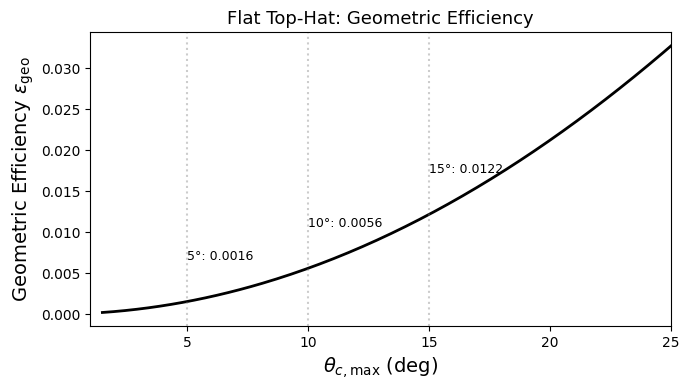

In [5]:
theta_max_arr = np.linspace(1.5, 25, 200)
geo_eff_arr   = [geometric_efficiency_flat(t) for t in theta_max_arr]

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(theta_max_arr, geo_eff_arr, 'k-', lw=2)
ax.set_xlabel(r'$\theta_{c,\max}$ (deg)', fontsize=14)
ax.set_ylabel(r'Geometric Efficiency $\epsilon_{\text{geo}}$', fontsize=14)
ax.set_title('Flat Top-Hat: Geometric Efficiency', fontsize=13)

# Mark some reference values
for t_ref in [5, 10, 15]:
    eff = geometric_efficiency_flat(t_ref)
    ax.axvline(t_ref, ls=':', alpha=0.4, color='grey')
    ax.annotate(f'{t_ref}°: {eff:.4f}', xy=(t_ref, eff), fontsize=9,
                xytext=(t_ref+0.01, eff + 0.005))

ax.set_xlim(1, 25)
plt.tight_layout()
plt.show()

## 3. Likelihood and Walker Initialization

The likelihood combines **shape** and **rate** terms (see the CvM explanation above):

1. **Monte Carlo generation**: draw $\hat{E}_{\rm iso}$ from the cut-off power law, $E_p$ from the log-normal, assign random redshifts and $\theta_c$ values from the flat distribution.
2. **Detection cuts**: keep events with $F_p > 4\,\text{ph}/\text{cm}^2/\text{s}$ and $E_p \in [50, 10\,000]\,\text{keV}$.
3. **Shape likelihood**: CvM test on $F_p$ and $E_p$ distributions $\to \ln \mathcal{L}_{\rm shape}$.
4. **Rate likelihood**: Poisson probability of observing $N_{\rm obs}$ given $N_{\rm pred}$ $\to \ln \mathcal{L}_{\rm rate}$.

$$
\ln \mathcal{L} = \underbrace{\ln p_{\rm CvM}(F_p) + \ln p_{\rm CvM}(E_p)}_{\text{shape}} + \underbrace{\ln \text{Poiss}(N_{\rm obs}\mid N_{\rm pred})}_{\text{rate}}
$$

In [6]:
def log_likelihood_flat_tophat(thetas, params_in, distances, k_interpolator, n_events=10_000):
    """Log-likelihood for the flat top-hat model."""
    theta_c_max, fj = thetas[4], thetas[5]

    gbm_eff              = 0.6
    geometric_efficiency = geometric_efficiency_flat(theta_c_max)
    triggered_years      = params_in.triggered_years
    epsilon              = geometric_efficiency * fj

    n_years              = triggered_years
    intrinsic_rate       = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events      = intrinsic_rate * n_years

    # Run the simplified Monte Carlo
    results = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)

    # Apply detection cuts
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])

    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf

    triggered_events    = np.sum(trigger_mask)
    physics_efficiency  = triggered_events / n_events
    predicted_detections = expected_events * physics_efficiency
    observed_detections  = params_in.yearly_rate * params_in.triggered_years

    # Score functions
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)

    return l1 + l2 + l3, l1, l2, l3, physics_efficiency


def initialize_walkers_flat(n_walkers):
    """Initialize walkers within the prior bounds."""
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),        # A_index
        np.random.uniform(2, 4, n_walkers),        # L_L0
        np.random.uniform(2, 4, n_walkers),        # L_mu_E
        np.random.uniform(0.2, 1, n_walkers),      # sigma_E
        np.random.uniform(5, 15, n_walkers),       # theta_c_max
        np.random.uniform(0.3, 0.8, n_walkers),    # fj
    ])

print(f"Example initial walker: {initialize_walkers_flat(1)[0]}")

Example initial walker: [2.37454012 3.90142861 3.46398788 0.67892679 6.5601864  0.37799726]


## 4. Initialize the Simulation and Run MCMC

In [7]:
# Initialize simulation (loads GBM data, creates interpolators)
params = {
    "alpha"       : -0.67,
    "beta_s"      : -2.59,
    "n"           : 2,
    "theta_c"     : 3.4,
    "theta_v_max" : 10,
    "z_model"     : 'fiducial_Hrad_TEST_A1.0'  # Change to 'fiducial_Hrad_TEST_A1.0' to use Tutorial 0 samples
}

default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params)
print(f"Catalogue events: {len(default_params.pflux_data)}")
print(f"Yearly rate: {default_params.yearly_rate:.1f} GRBs/yr")
print(f"Triggered years: {default_params.triggered_years:.1f}")

Using redshift model: samples_fiducial_Hrad_TEST_A1.0.dat with 360832 BNSs.
Continuing without P(z) interpolator.
Defaulting to values for Fiducial populations
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 325, Trigger years: 17.50, Yearly rate: 18.58 events/year
Catalogue events: 268
Yearly rate: 18.6 GRBs/yr
Triggered years: 17.5


In [8]:
# Create output directory and configure MCMC
output_dir  = src.init.create_run_dir("tutorial1_tophat_flat")

n_walkers   = 20
n_steps     = 2000  # Use more steps (e.g. 50 000) for production runs

# Create the k-factor interpolator (redshift correction)
k_interpolator = create_k_interpolator()

# Build the log-probability function
log_probability_flat = create_log_probability_function(
    log_prior_func      = log_prior_flat_tophat,
    log_likelihood_func  = log_likelihood_flat_tophat,
    params_in            = default_params,
    k_interpolator       = k_interpolator
)

# Check for existing chain or start fresh
initial_pos, n_steps_remaining, backend = check_and_resume_mcmc(
    filename                = output_dir / "emcee.h5",
    n_steps                 = n_steps,
    initialize_walkers_func = initialize_walkers_flat,
    n_walkers               = n_walkers
)

# Run the MCMC
if n_steps_remaining > 0:
    sampler = run_mcmc(
        log_probability_func = log_probability_flat,
        initial_walkers      = initial_pos,
        n_iterations         = n_steps_remaining,
        n_walkers            = n_walkers,
        n_params             = N_PARAMS,
        backend              = backend,
    )
else:
    print("MCMC already complete, loading results.")

Loading existing directory  : Output_files/tutorial1_tophat_flat
Already completed this run
MCMC already complete, loading results.


## 5. Results: CDFs and Diagnostics

The `TopHatPlotter` provides all the standard diagnostic plots.

In [9]:
backend_flat = emcee.backends.HDFBackend(output_dir / "emcee.h5")
BURN_IN = 200

plotter = TopHatPlotter(
    backend     = backend_flat,
    output_dir  = output_dir,
    model_type  = "flat_theta",
    burn_in     = BURN_IN,
    thin        = 10
)

### Corner Plot

(3600, 6)


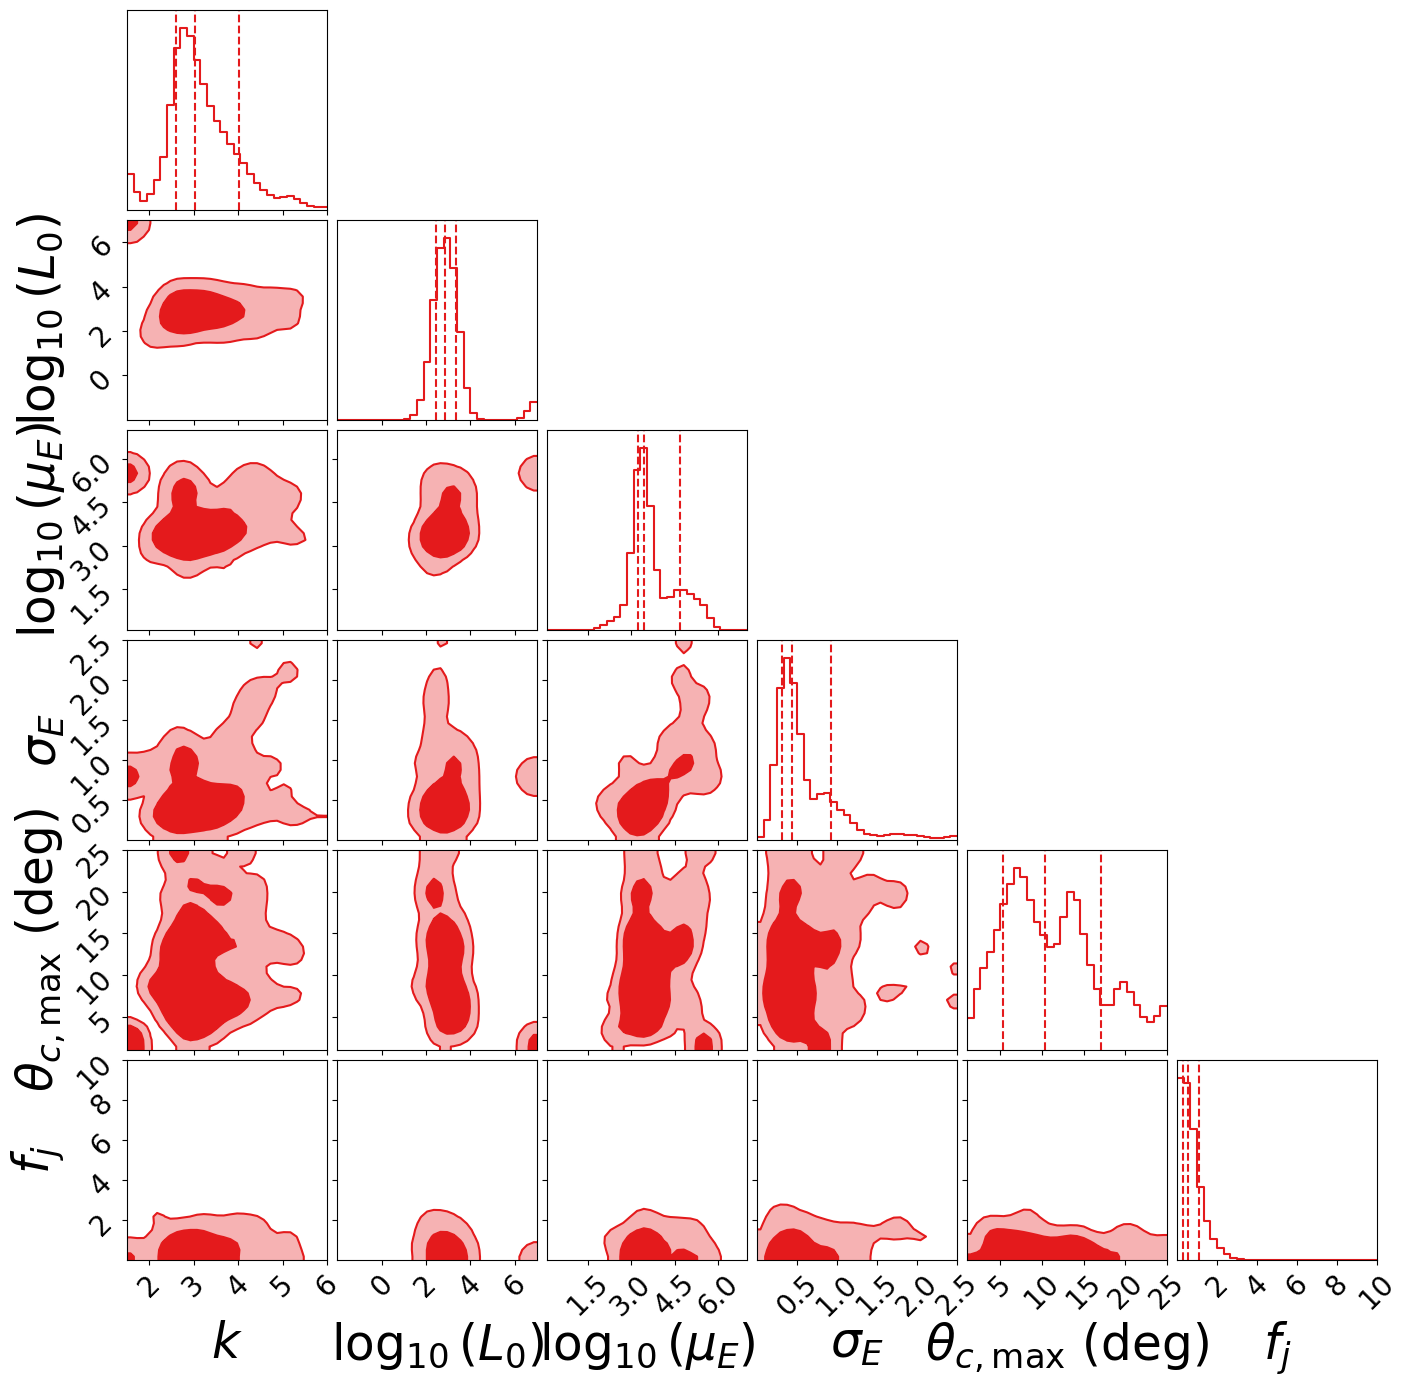

In [17]:
plotter.plot_corner(filename="corner_flat_tophat.pdf")

### CDF Comparison

Compare the simulated peak flux and peak energy CDFs against the observed Fermi-GBM data.

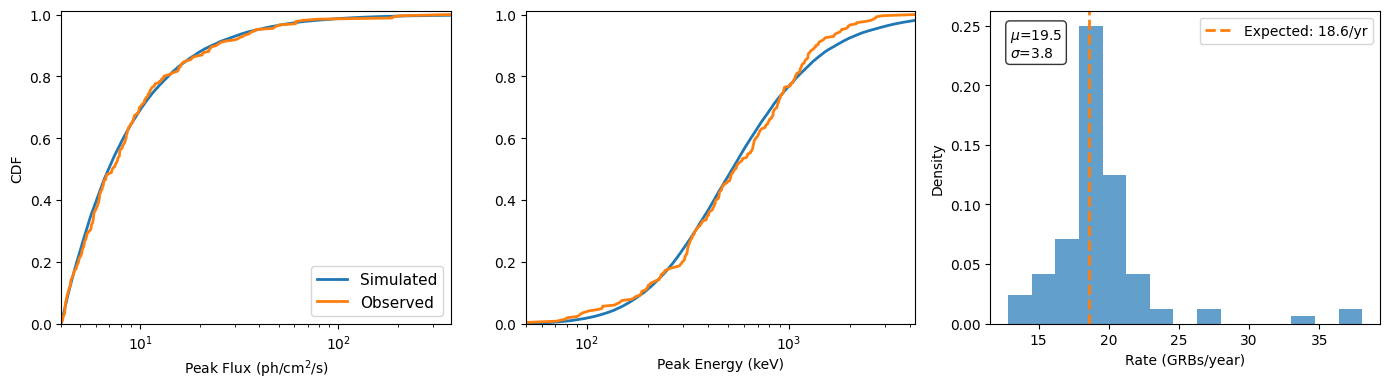

In [18]:
distances = compute_luminosity_distance(default_params.z_arr)

plotter.plot_cdf_comparison(
    mc_func          = simplified_montecarlo,
    params_in        = default_params,
    distances        = distances,
    k_interpolator   = k_interpolator,
    geometric_eff_func = geometric_efficiency_flat,
    n_samples        = 100,
    filename         = "cdf_flat_tophat.pdf"
)

### Summary Table

In [12]:
print(plotter.summary_table())

\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $3.033_{-0.441}^{+0.974}$ \\
$\log_{10}(L_0)$ & $2.876_{-0.446}^{+0.477}$ \\
$\log_{10}(\mu_E)$ & $3.453_{-0.220}^{+1.245}$ \\
$\sigma_E$ & $0.442_{-0.131}^{+0.479}$ \\
$\theta_{c,\max}$ (deg) & $10.344_{-5.095}^{+6.764}$ \\
$f_j$ & $0.536_{-0.248}^{+0.551}$ \\
\hline
\end{tabular}


### Autocorrelation

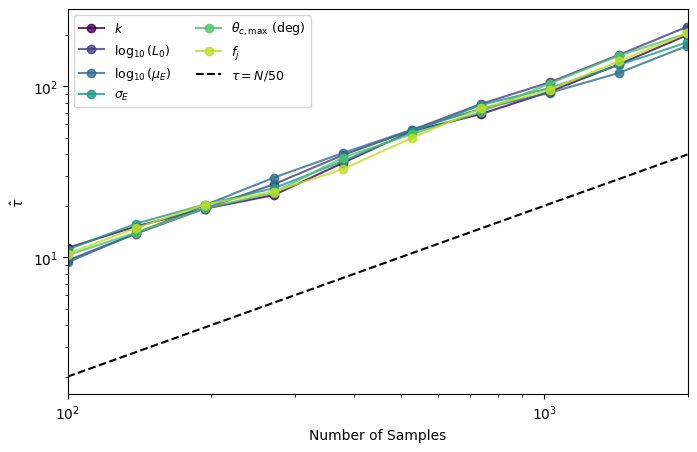

In [19]:
plotter.plot_autocorrelation()

---

## 6. Extracting the $f_j$ Posterior at a Fixed Viewing Angle

A useful exercise is to **fix the median opening angle** and study how the jet fraction $f_j$ is constrained. We choose $\theta^* = (\theta_{c,\max} + 1°) / 2$, which is the median of the flat $\theta_c$ distribution.

### Procedure:
1. Extract full posterior samples
2. Compute $\theta^* = (\theta_{c,\max} + 1) / 2$ for each sample
3. Slice the $f_j$ posterior at a given fixed $\theta^*$

In [14]:
# Get the full posterior samples
samples = backend_flat.get_chain(discard=BURN_IN, thin=10, flat=True)

theta_c_max_samples = samples[:, 4]  # theta_c_max
fj_samples          = samples[:, 5]  # fj

# Compute the median angle for each sample: theta* = (theta_c_max + 1) / 2
theta_star = (theta_c_max_samples + 1) / 2

print(f"theta* range: [{theta_star.min():.1f}, {theta_star.max():.1f}] deg")
print(f"theta* median: {np.median(theta_star):.1f} deg")
print(f"fj median: {np.median(fj_samples):.3f}")

theta* range: [1.6, 13.0] deg
theta* median: 5.7 deg
fj median: 0.536


Conditioning on θ* = 5.7° ± 0.2°
Selected 182 / 3600 samples


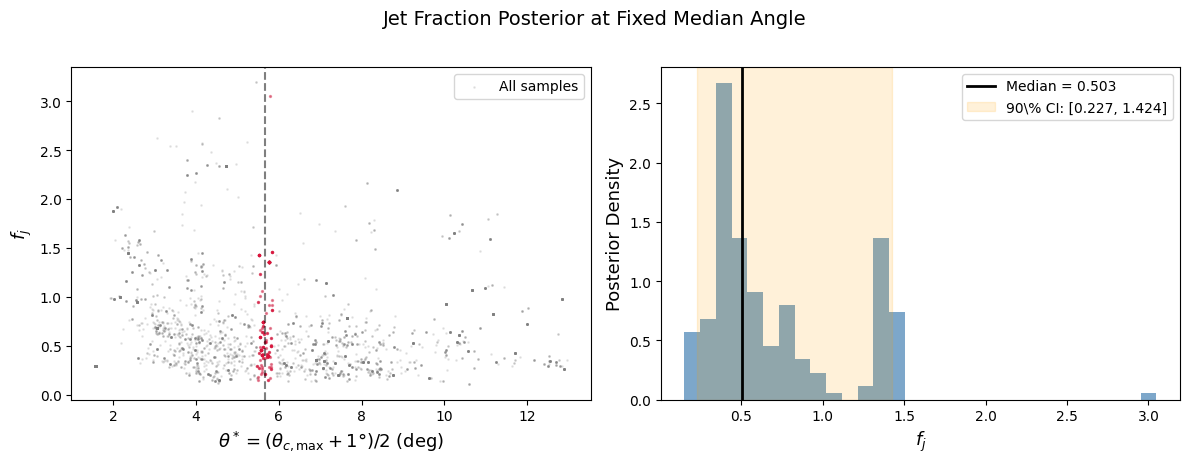

In [15]:
# Fix theta* at a specific value and look at fj conditioned on that
# We select samples where theta* is close to a target value
target_theta_star = np.median(theta_star)
tolerance         = 0.2  # degrees

mask = np.abs(theta_star - target_theta_star) < tolerance
fj_conditional = fj_samples[mask]

print(f"Conditioning on θ* = {target_theta_star:.1f}° ± {tolerance}°")
print(f"Selected {np.sum(mask)} / {len(mask)} samples")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: 2D scatter of theta* vs fj
ax1.scatter(theta_star, fj_samples, s=1, alpha=0.15, color='grey', label='All samples')
ax1.scatter(theta_star[mask], fj_samples[mask], s=2, alpha=0.4, color='crimson')
ax1.axvline(target_theta_star, ls='--', color='k', alpha=0.5)
ax1.set_xlabel(r'$\theta^* = (\theta_{c,\max} + 1°) / 2$ (deg)', fontsize=13)
ax1.set_ylabel(r'$f_j$', fontsize=13)
ax1.legend(fontsize=10)

# Right: fj posterior conditioned on theta*
lo, med, hi = np.percentile(fj_conditional, [5, 50, 95])
ax2.hist(fj_conditional, bins=30, density=True, alpha=0.7, color='steelblue')
ax2.axvline(med, ls='-', color='k', lw=2, label=f'Median = {med:.3f}')
ax2.axvspan(lo, hi, alpha=0.15, color='orange', label=f'90\% CI: [{lo:.3f}, {hi:.3f}]')
ax2.set_xlabel(r'$f_j$', fontsize=13)
ax2.set_ylabel('Posterior Density', fontsize=13)
ax2.legend(fontsize=10)

plt.suptitle('Jet Fraction Posterior at Fixed Median Angle', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(output_dir / "fj_posterior_fixed_theta.pdf", dpi=300, bbox_inches='tight')
plt.show()

---

## Summary

In this tutorial we demonstrated:

1. **Prior definition** — flat priors on 6 parameters for the top-hat model
2. **Geometric efficiency** — how $\epsilon_{\text{geo}}(\theta_{c,\max})$ is computed for a uniform $\theta_c$ distribution
3. **MCMC** — setting up and running `emcee` with the top-hat likelihood
4. **CDF comparison** — posterior predictive checks against Fermi-GBM data
5. **Conditional $f_j$ posterior** — fixing $\theta^* = (\theta_{c,\max} + 1°)/2$ and extracting the jet fraction

**Next:** Tutorial 2 covers the full **structured jet model** with time evolution and richer diagnostics.

---

## 🏋️ Exercise: Universal (Fixed) Opening Angle Model

In this exercise you will replace the flat $\theta_c$ distribution with a **universal opening angle** — all BNS mergers produce jets with the same $\theta_c$. The skeleton code is provided — fill in the missing pieces marked with `???`.

### Background

In the main tutorial, $\theta_c$ was drawn from a flat distribution between 1° and $\theta_{c,\max}$. A simpler alternative is to assume that **all BNS mergers produce jets with exactly the same opening angle** $\theta_c$:

$$
p(\theta_c) = \delta(\theta_c - \theta_c^*)
$$

This is the **universal** (or fixed) opening angle model. It has a major simplification: the geometric efficiency becomes a simple closed-form expression (recall the derivation above):

$$
\epsilon_{\rm geo}^{\rm fixed}(\theta_c^*) = 1 - \cos\theta_c^*
$$

No averaging over $\theta_c$ is needed because every jet has the same angle.

Your task: replace `theta_c_max` with `theta_c_fixed` in the prior and likelihood, and use the simplified geometric efficiency.

### Step 1: Define the prior for the fixed-angle model

The parameter `theta_c_max` is replaced by `theta_c_fixed` (the single universal opening angle, in degrees).

In [16]:
N_PARAMS_EX  = 6
PARAM_NAMES_EX = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_fixed", "fj"]

def log_prior_fixed_angle(thetas):
    """Flat prior for the universal (fixed) opening-angle model."""
    A_index, L_L0, L_mu_E, sigma_E, theta_c_fixed, fj = thetas

    if not (1.5 < A_index       < 12):  return -inf
    if not (-2  < L_L0          < 7):   return -inf
    if not (0.1 < L_mu_E        < 7):   return -inf
    if not (0   < sigma_E       < 2.5): return -inf
    # -------------------------------------------------------
    # ✏️ EXERCISE: Add the prior bound for theta_c_fixed (in degrees).
    # What is a reasonable range? (Hint: between ~1° and ~25°)
    # -------------------------------------------------------
    if not (??? < theta_c_fixed < ???): return -inf   # <-- FIX THIS
    if not (0   < fj            < 10):  return -inf

    return 0.0

# Test
# print(log_prior_fixed_angle([3, 1, 3, 0.5, 5.0, 0.5]))

SyntaxError: invalid syntax (3142948264.py, line 16)

### Step 2: Modify the likelihood to use the fixed-angle geometric efficiency

The key change: replace `geometric_efficiency_flat(theta_c_max)` with the simple $1 - \cos\theta_c^*$ formula.

In [ ]:
def log_likelihood_fixed_angle(thetas, params_in, distances, k_interpolator, n_events=10_000):
    """Log-likelihood for the top-hat model with a FIXED (universal) opening angle."""
    theta_c_fixed = thetas[4]   # single angle in degrees
    fj            = thetas[5]

    gbm_eff          = 0.6
    triggered_years  = params_in.triggered_years

    # -------------------------------------------------------
    # ✏️ EXERCISE: Compute the geometric efficiency for a fixed angle.
    # Recall: epsilon_geo = 1 - cos(theta_c)  (theta_c in RADIANS!)
    # Hint: geometric_efficiency = 1 - np.cos(np.deg2rad(???))
    # -------------------------------------------------------
    geometric_efficiency = ???   # <-- FIX THIS

    epsilon          = geometric_efficiency * fj
    n_years          = triggered_years
    intrinsic_rate   = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events  = intrinsic_rate * n_years

    # Run the Monte Carlo (the spectral part is unchanged — thetas[:4] are the same)
    results = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)

    # Apply detection cuts (unchanged)
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])

    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf

    triggered_events     = np.sum(trigger_mask)
    physics_efficiency   = triggered_events / n_events
    predicted_detections = expected_events * physics_efficiency
    observed_detections  = params_in.yearly_rate * params_in.triggered_years

    # Score functions (unchanged)
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)

    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

### Step 3: Initialize walkers and run a short MCMC

Update the walker initialisation for `theta_c_fixed` and run a short chain.

In [ ]:
def initialize_walkers_fixed_angle(n_walkers):
    """Initialize walkers for the fixed-angle model."""
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),        # A_index
        np.random.uniform(2, 4, n_walkers),        # L_L0
        np.random.uniform(2, 4, n_walkers),        # L_mu_E
        np.random.uniform(0.2, 1, n_walkers),      # sigma_E
        # -------------------------------------------------------
        # ✏️ EXERCISE: Add initial values for theta_c_fixed (degrees)
        # Hint: np.random.uniform(???, ???, n_walkers)
        # -------------------------------------------------------
        np.random.uniform(???, ???, n_walkers),     # theta_c_fixed  <-- FIX THIS
        np.random.uniform(0.3, 0.8, n_walkers),    # fj
    ])


# -------------------------------------------------------
# ✏️ EXERCISE: Build the log-probability and run a short MCMC.
# Use create_log_probability_function with your new prior & likelihood,
# then run ~500 steps to see if the chain converges.
# -------------------------------------------------------

# output_dir_ex = src.init.create_run_dir("tutorial1_exercise_fixed_angle")
#
# log_probability_ex = create_log_probability_function(
#     log_prior_func       = log_prior_fixed_angle,
#     log_likelihood_func  = log_likelihood_fixed_angle,
#     params_in            = default_params,
#     k_interpolator       = k_interpolator
# )
#
# pos_ex = initialize_walkers_fixed_angle(20)
# backend_ex = emcee.backends.HDFBackend(output_dir_ex / "emcee.h5")
# backend_ex.reset(20, N_PARAMS_EX)
#
# sampler_ex = run_mcmc(
#     log_probability_func = log_probability_ex,
#     initial_walkers      = pos_ex,
#     n_iterations         = 500,
#     n_walkers            = 20,
#     n_params             = N_PARAMS_EX,
#     backend              = backend_ex,
# )
#
# print("Exercise MCMC complete!")

### 🤔 Questions to Think About

Once you have the exercise running, consider:

1. **Geometric efficiency**: How does $\epsilon_{\rm geo} = 1 - \cos\theta_c^*$ compare to the flat-distribution formula for typical $\theta_c$ values? Plot both on the same axes.

2. **Constraint on $\theta_c^*$**: How does the MCMC constrain $\theta_c^*$ more differently than $\theta_{c,\max}$ in the original model? Is the posterior narrower or wider? Why? (Hint: Think of the efficiency)

3. **Physical realism**: The universal model assumes every BNS merger produces a jet with exactly the same opening angle. Is this a reasonable assumption? *What physical effects could cause a distribution of $\theta_c$ values*?

4. **$f_j$ posterior**: Compare the $f_j$ posterior between the universal and flat $\theta_c$ models. Does the universal model prefer higher or lower $f_j$ values? Why?

**Next:** Tutorial 2 covers the full **structured jet model** with time evolution and richer diagnostics.